<a href="https://colab.research.google.com/github/atefeharani/UCI-Human-Activity-Recognition-Using-Pytorch/blob/main/HAR_CNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# **Install**

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 8.0 MB/s 


# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

# **Dataset 🗂️**

## Load dataset

In [ ]:
!cp '/content/drive/MyDrive/Howsam/session6_rnn/UCI HAR Dataset.zip' /content/

In [ ]:
!unzip '/content/UCI HAR Dataset.zip'  

Archive:  /content/UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [ ]:
def har_dataset(phase):
  x = []
  data_dir = f'UCI HAR Dataset/{phase}/Inertial Signals/*'
  lis = glob.glob(data_dir)
  lis.sort()
  for file_dir in lis:
    x.append(np.loadtxt(file_dir))

  y = np.loadtxt(f'UCI HAR Dataset/{phase}/y_{phase}.txt')
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y


In [ ]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

<ipython-input-7-1d1b5fb3b677>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  x = torch.FloatTensor(x).permute(1, 2, 0)


In [ ]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [ ]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

Activities are the class labels. It is a 6 class classification

    0: Walking

    1: Walking_Upstairs

    2: Walking_Downstairs

    3: Sitting

    4: Standing

    5: Laying


In [ ]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=6).to(device)   #task='multiclass', num_classes=6
 
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Model 🧠**

## CNN-LSTM

In [ ]:
class CNNLSTM(nn.Module):
  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, num_cls):
    super().__init__()
    
    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)
    
    self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn2 = nn.BatchNorm1d(cnn_hidden_size)

    self.pool = nn.MaxPool1d(2, 2)
    
    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers, batch_first=True)

    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    # y = self.pool(y)

    y = y.permute(0, 2, 1)
    y, _ = self.lstm(y)
    y = self.fc(y)
    return y.mean(dim=1)

In [ ]:
model = CNNLSTM(9, 32, 128, 3, 6).to(device)
model

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNNLSTM(
  (conv1): Conv1d(9, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(32, 128, num_layers=3, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 400

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 29/29 [00:01<00:00, 19.45batch/s, accuracy=0.977, loss=0.0501]


Valid: Loss = 0.4441, Acc = 0.9152



Epoch 1: 100%|██████████| 29/29 [00:01<00:00, 20.71batch/s, accuracy=0.977, loss=0.0468]


Valid: Loss = 0.4367, Acc = 0.9145



Epoch 2: 100%|██████████| 29/29 [00:01<00:00, 22.11batch/s, accuracy=0.976, loss=0.0465]


Valid: Loss = 0.4453, Acc = 0.9135



Epoch 3: 100%|██████████| 29/29 [00:01<00:00, 21.82batch/s, accuracy=0.978, loss=0.0445]


Valid: Loss = 0.4435, Acc = 0.9128



Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 21.61batch/s, accuracy=0.978, loss=0.0458]


Valid: Loss = 0.4601, Acc = 0.9087



Epoch 5: 100%|██████████| 29/29 [00:01<00:00, 21.64batch/s, accuracy=0.978, loss=0.0431]


Valid: Loss = 0.457, Acc = 0.9158



Epoch 6: 100%|██████████| 29/29 [00:01<00:00, 21.86batch/s, accuracy=0.979, loss=0.0418]


Valid: Loss = 0.4562, Acc = 0.9114



Epoch 7: 100%|██████████| 29/29 [00:01<00:00, 21.91batch/s, accuracy=0.978, loss=0.0421]


Valid: Loss = 0.4677, Acc = 0.9114



Epoch 8: 100%|██████████| 29/29 [00:01<00:00, 21.77batch/s, accuracy=0.98, loss=0.0414]


Valid: Loss = 0.4723, Acc = 0.9128



Epoch 9: 100%|██████████| 29/29 [00:01<00:00, 19.55batch/s, accuracy=0.979, loss=0.0447]


Valid: Loss = 0.4761, Acc = 0.9087



Epoch 10: 100%|██████████| 29/29 [00:01<00:00, 18.81batch/s, accuracy=0.98, loss=0.0404]


Valid: Loss = 0.4753, Acc = 0.9108



Epoch 11: 100%|██████████| 29/29 [00:01<00:00, 22.08batch/s, accuracy=0.979, loss=0.0417]


Valid: Loss = 0.4796, Acc = 0.9087



Epoch 12: 100%|██████████| 29/29 [00:01<00:00, 21.66batch/s, accuracy=0.98, loss=0.0415]


Valid: Loss = 0.4651, Acc = 0.906



Epoch 13: 100%|██████████| 29/29 [00:01<00:00, 21.46batch/s, accuracy=0.98, loss=0.0419]


Valid: Loss = 0.4689, Acc = 0.9053



Epoch 14: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.983, loss=0.0373]


Valid: Loss = 0.4748, Acc = 0.9094



Epoch 15: 100%|██████████| 29/29 [00:01<00:00, 21.72batch/s, accuracy=0.982, loss=0.0397]


Valid: Loss = 0.4804, Acc = 0.9077



Epoch 16: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.98, loss=0.0423]


Valid: Loss = 0.4766, Acc = 0.9087



Epoch 17: 100%|██████████| 29/29 [00:01<00:00, 21.44batch/s, accuracy=0.981, loss=0.0396]


Valid: Loss = 0.4766, Acc = 0.904



Epoch 18: 100%|██████████| 29/29 [00:01<00:00, 21.15batch/s, accuracy=0.979, loss=0.0391]


Valid: Loss = 0.4849, Acc = 0.9043



Epoch 19: 100%|██████████| 29/29 [00:01<00:00, 21.41batch/s, accuracy=0.981, loss=0.0403]


Valid: Loss = 0.4852, Acc = 0.9074



Epoch 20: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.979, loss=0.0435]


Valid: Loss = 0.485, Acc = 0.905



Epoch 21: 100%|██████████| 29/29 [00:01<00:00, 21.45batch/s, accuracy=0.98, loss=0.0405]


Valid: Loss = 0.4722, Acc = 0.9063



Epoch 22: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.979, loss=0.0404]


Valid: Loss = 0.4745, Acc = 0.908



Epoch 23: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.981, loss=0.0409]


Valid: Loss = 0.4823, Acc = 0.906



Epoch 24: 100%|██████████| 29/29 [00:01<00:00, 20.02batch/s, accuracy=0.98, loss=0.0442]


Valid: Loss = 0.472, Acc = 0.9057



Epoch 25: 100%|██████████| 29/29 [00:01<00:00, 21.01batch/s, accuracy=0.982, loss=0.0393]


Valid: Loss = 0.4732, Acc = 0.9033



Epoch 26: 100%|██████████| 29/29 [00:01<00:00, 21.41batch/s, accuracy=0.98, loss=0.0418]


Valid: Loss = 0.478, Acc = 0.903



Epoch 27: 100%|██████████| 29/29 [00:01<00:00, 20.90batch/s, accuracy=0.982, loss=0.0405]


Valid: Loss = 0.4786, Acc = 0.9074



Epoch 28: 100%|██████████| 29/29 [00:01<00:00, 21.12batch/s, accuracy=0.98, loss=0.0401]


Valid: Loss = 0.4742, Acc = 0.9074



Epoch 29: 100%|██████████| 29/29 [00:01<00:00, 21.47batch/s, accuracy=0.982, loss=0.0383]


Valid: Loss = 0.4778, Acc = 0.904



Epoch 30: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.981, loss=0.0427]


Valid: Loss = 0.4733, Acc = 0.9114



Epoch 31: 100%|██████████| 29/29 [00:01<00:00, 20.98batch/s, accuracy=0.979, loss=0.0438]


Valid: Loss = 0.4777, Acc = 0.9053



Epoch 32: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.983, loss=0.0371]


Valid: Loss = 0.4709, Acc = 0.9067



Epoch 33: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.983, loss=0.0369]


Valid: Loss = 0.4751, Acc = 0.9077



Epoch 34: 100%|██████████| 29/29 [00:01<00:00, 21.70batch/s, accuracy=0.98, loss=0.0402]


Valid: Loss = 0.4667, Acc = 0.9057



Epoch 35: 100%|██████████| 29/29 [00:01<00:00, 21.42batch/s, accuracy=0.982, loss=0.0387]


Valid: Loss = 0.4727, Acc = 0.9016



Epoch 36: 100%|██████████| 29/29 [00:01<00:00, 21.56batch/s, accuracy=0.985, loss=0.0363]


Valid: Loss = 0.4818, Acc = 0.904



Epoch 37: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.981, loss=0.0406]


Valid: Loss = 0.4764, Acc = 0.906



Epoch 38: 100%|██████████| 29/29 [00:01<00:00, 21.51batch/s, accuracy=0.981, loss=0.0411]


Valid: Loss = 0.4699, Acc = 0.905



Epoch 39: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.98, loss=0.041]


Valid: Loss = 0.4487, Acc = 0.9141



Epoch 40: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.982, loss=0.0383]


Valid: Loss = 0.4612, Acc = 0.9084



Epoch 41: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.983, loss=0.0377]


Valid: Loss = 0.4622, Acc = 0.907



Epoch 42: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.983, loss=0.037]


Valid: Loss = 0.4711, Acc = 0.9084



Epoch 43: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.981, loss=0.0391]


Valid: Loss = 0.4743, Acc = 0.903



Epoch 44: 100%|██████████| 29/29 [00:01<00:00, 21.54batch/s, accuracy=0.983, loss=0.037]


Valid: Loss = 0.4686, Acc = 0.9074



Epoch 45: 100%|██████████| 29/29 [00:01<00:00, 21.41batch/s, accuracy=0.984, loss=0.0352]


Valid: Loss = 0.4719, Acc = 0.9094



Epoch 46: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.981, loss=0.0415]


Valid: Loss = 0.4685, Acc = 0.9084



Epoch 47: 100%|██████████| 29/29 [00:01<00:00, 21.56batch/s, accuracy=0.98, loss=0.0386]


Valid: Loss = 0.4736, Acc = 0.9091



Epoch 48: 100%|██████████| 29/29 [00:01<00:00, 21.48batch/s, accuracy=0.982, loss=0.0383]


Valid: Loss = 0.4667, Acc = 0.9077



Epoch 49: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.981, loss=0.0371]


Valid: Loss = 0.4688, Acc = 0.9101



Epoch 50: 100%|██████████| 29/29 [00:01<00:00, 21.49batch/s, accuracy=0.98, loss=0.0367]


Valid: Loss = 0.4671, Acc = 0.9128



Epoch 51: 100%|██████████| 29/29 [00:01<00:00, 21.63batch/s, accuracy=0.985, loss=0.034]


Valid: Loss = 0.4741, Acc = 0.9087



Epoch 52: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.982, loss=0.0372]


Valid: Loss = 0.4738, Acc = 0.907



Epoch 53: 100%|██████████| 29/29 [00:01<00:00, 20.88batch/s, accuracy=0.983, loss=0.0341]


Valid: Loss = 0.4727, Acc = 0.9104



Epoch 54: 100%|██████████| 29/29 [00:01<00:00, 20.10batch/s, accuracy=0.98, loss=0.0385]


Valid: Loss = 0.4768, Acc = 0.9077



Epoch 55: 100%|██████████| 29/29 [00:01<00:00, 20.98batch/s, accuracy=0.979, loss=0.0396]


Valid: Loss = 0.4762, Acc = 0.9101



Epoch 56: 100%|██████████| 29/29 [00:01<00:00, 21.59batch/s, accuracy=0.982, loss=0.0392]


Valid: Loss = 0.4686, Acc = 0.9091



Epoch 57: 100%|██████████| 29/29 [00:01<00:00, 21.50batch/s, accuracy=0.983, loss=0.0365]


Valid: Loss = 0.4681, Acc = 0.9104



Epoch 58: 100%|██████████| 29/29 [00:01<00:00, 21.55batch/s, accuracy=0.982, loss=0.039]


Valid: Loss = 0.4644, Acc = 0.9084



Epoch 59: 100%|██████████| 29/29 [00:01<00:00, 21.60batch/s, accuracy=0.984, loss=0.0358]


Valid: Loss = 0.4769, Acc = 0.9111



Epoch 60: 100%|██████████| 29/29 [00:01<00:00, 21.63batch/s, accuracy=0.979, loss=0.0438]


Valid: Loss = 0.4676, Acc = 0.9111



Epoch 61: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.981, loss=0.0373]


Valid: Loss = 0.4733, Acc = 0.9057



Epoch 62: 100%|██████████| 29/29 [00:01<00:00, 21.65batch/s, accuracy=0.982, loss=0.0398]


Valid: Loss = 0.4666, Acc = 0.9077



Epoch 63: 100%|██████████| 29/29 [00:01<00:00, 21.44batch/s, accuracy=0.983, loss=0.0369]


Valid: Loss = 0.458, Acc = 0.9114



Epoch 64: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.979, loss=0.0419]


Valid: Loss = 0.4498, Acc = 0.9162



Epoch 65: 100%|██████████| 29/29 [00:01<00:00, 21.46batch/s, accuracy=0.986, loss=0.0343]


Valid: Loss = 0.4571, Acc = 0.9128



Epoch 66: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.982, loss=0.0366]


Valid: Loss = 0.4735, Acc = 0.9087



Epoch 67: 100%|██████████| 29/29 [00:01<00:00, 21.42batch/s, accuracy=0.982, loss=0.0391]


Valid: Loss = 0.4595, Acc = 0.9101



Epoch 68: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.985, loss=0.0332]


Valid: Loss = 0.4654, Acc = 0.9111



Epoch 69: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.985, loss=0.0347]


Valid: Loss = 0.4689, Acc = 0.9114



Epoch 70: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.985, loss=0.0334]


Valid: Loss = 0.4828, Acc = 0.9104



Epoch 71: 100%|██████████| 29/29 [00:01<00:00, 21.23batch/s, accuracy=0.982, loss=0.0416]


Valid: Loss = 0.4731, Acc = 0.9148



Epoch 72: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.984, loss=0.0355]


Valid: Loss = 0.4746, Acc = 0.9114



Epoch 73: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.981, loss=0.0407]


Valid: Loss = 0.474, Acc = 0.9114



Epoch 74: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.982, loss=0.0359]


Valid: Loss = 0.4638, Acc = 0.9152



Epoch 75: 100%|██████████| 29/29 [00:01<00:00, 21.71batch/s, accuracy=0.983, loss=0.0357]


Valid: Loss = 0.4686, Acc = 0.9141



Epoch 76: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.983, loss=0.038]


Valid: Loss = 0.465, Acc = 0.908



Epoch 77: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.984, loss=0.0363]


Valid: Loss = 0.4709, Acc = 0.9074



Epoch 78: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.985, loss=0.0343]


Valid: Loss = 0.4794, Acc = 0.9121



Epoch 79: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.983, loss=0.0365]


Valid: Loss = 0.4672, Acc = 0.9091



Epoch 80: 100%|██████████| 29/29 [00:01<00:00, 21.37batch/s, accuracy=0.984, loss=0.0354]


Valid: Loss = 0.4807, Acc = 0.9101



Epoch 81: 100%|██████████| 29/29 [00:01<00:00, 21.42batch/s, accuracy=0.982, loss=0.0388]


Valid: Loss = 0.4747, Acc = 0.9101



Epoch 82: 100%|██████████| 29/29 [00:01<00:00, 21.61batch/s, accuracy=0.981, loss=0.0368]


Valid: Loss = 0.4734, Acc = 0.9131



Epoch 83: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.982, loss=0.0409]


Valid: Loss = 0.4619, Acc = 0.9169



Epoch 84: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.981, loss=0.0418]


Valid: Loss = 0.454, Acc = 0.9104



Epoch 85: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.982, loss=0.0382]


Valid: Loss = 0.4572, Acc = 0.9155



Epoch 86: 100%|██████████| 29/29 [00:01<00:00, 21.41batch/s, accuracy=0.984, loss=0.0345]


Valid: Loss = 0.4659, Acc = 0.9121



Epoch 87: 100%|██████████| 29/29 [00:01<00:00, 21.46batch/s, accuracy=0.985, loss=0.0338]


Valid: Loss = 0.4698, Acc = 0.9097



Epoch 88: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.985, loss=0.0336]


Valid: Loss = 0.4675, Acc = 0.9111



Epoch 89: 100%|██████████| 29/29 [00:01<00:00, 21.53batch/s, accuracy=0.983, loss=0.036]


Valid: Loss = 0.4695, Acc = 0.9087



Epoch 90: 100%|██████████| 29/29 [00:01<00:00, 21.39batch/s, accuracy=0.984, loss=0.0354]


Valid: Loss = 0.4672, Acc = 0.9148



Epoch 91: 100%|██████████| 29/29 [00:01<00:00, 21.49batch/s, accuracy=0.983, loss=0.0361]


Valid: Loss = 0.475, Acc = 0.906



Epoch 92: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.982, loss=0.0378]


Valid: Loss = 0.4737, Acc = 0.9118



Epoch 93: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.983, loss=0.034]


Valid: Loss = 0.4757, Acc = 0.9114



Epoch 94: 100%|██████████| 29/29 [00:01<00:00, 20.05batch/s, accuracy=0.984, loss=0.0376]


Valid: Loss = 0.473, Acc = 0.9087



Epoch 95: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.983, loss=0.0354]


Valid: Loss = 0.4573, Acc = 0.9128



Epoch 96: 100%|██████████| 29/29 [00:01<00:00, 21.48batch/s, accuracy=0.982, loss=0.0376]


Valid: Loss = 0.4574, Acc = 0.9145



Epoch 97: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.984, loss=0.032]


Valid: Loss = 0.4565, Acc = 0.9138



Epoch 98: 100%|██████████| 29/29 [00:01<00:00, 21.17batch/s, accuracy=0.985, loss=0.0347]


Valid: Loss = 0.4703, Acc = 0.9094



Epoch 99: 100%|██████████| 29/29 [00:01<00:00, 21.39batch/s, accuracy=0.981, loss=0.039]


Valid: Loss = 0.456, Acc = 0.9108



Epoch 100: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.982, loss=0.0371]


Valid: Loss = 0.4642, Acc = 0.9111



Epoch 101: 100%|██████████| 29/29 [00:01<00:00, 21.01batch/s, accuracy=0.983, loss=0.0364]


Valid: Loss = 0.4661, Acc = 0.9114



Epoch 102: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.981, loss=0.0391]


Valid: Loss = 0.4584, Acc = 0.9125



Epoch 103: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.983, loss=0.0338]


Valid: Loss = 0.4669, Acc = 0.9104



Epoch 104: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.983, loss=0.0415]


Valid: Loss = 0.4693, Acc = 0.9091



Epoch 105: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.984, loss=0.0345]


Valid: Loss = 0.468, Acc = 0.9141



Epoch 106: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.986, loss=0.0317]


Valid: Loss = 0.4694, Acc = 0.9128



Epoch 107: 100%|██████████| 29/29 [00:01<00:00, 21.37batch/s, accuracy=0.985, loss=0.0331]


Valid: Loss = 0.467, Acc = 0.9148



Epoch 108: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.985, loss=0.0327]


Valid: Loss = 0.4662, Acc = 0.9135



Epoch 109: 100%|██████████| 29/29 [00:01<00:00, 20.58batch/s, accuracy=0.986, loss=0.0325]


Valid: Loss = 0.4765, Acc = 0.9128



Epoch 110: 100%|██████████| 29/29 [00:01<00:00, 20.82batch/s, accuracy=0.985, loss=0.0346]


Valid: Loss = 0.4776, Acc = 0.9067



Epoch 111: 100%|██████████| 29/29 [00:01<00:00, 20.49batch/s, accuracy=0.986, loss=0.0313]


Valid: Loss = 0.4771, Acc = 0.9104



Epoch 112: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.988, loss=0.0283]


Valid: Loss = 0.4908, Acc = 0.9111



Epoch 113: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.983, loss=0.0355]


Valid: Loss = 0.4705, Acc = 0.9125



Epoch 114: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.984, loss=0.0398]


Valid: Loss = 0.4788, Acc = 0.9114



Epoch 115: 100%|██████████| 29/29 [00:01<00:00, 21.54batch/s, accuracy=0.983, loss=0.0359]


Valid: Loss = 0.4748, Acc = 0.9091



Epoch 116: 100%|██████████| 29/29 [00:01<00:00, 21.51batch/s, accuracy=0.986, loss=0.0339]


Valid: Loss = 0.4756, Acc = 0.9077



Epoch 117: 100%|██████████| 29/29 [00:01<00:00, 20.16batch/s, accuracy=0.986, loss=0.0332]


Valid: Loss = 0.4709, Acc = 0.9148



Epoch 118: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.985, loss=0.0347]


Valid: Loss = 0.4645, Acc = 0.9155



Epoch 119: 100%|██████████| 29/29 [00:01<00:00, 21.23batch/s, accuracy=0.982, loss=0.0387]


Valid: Loss = 0.4681, Acc = 0.9152



Epoch 120: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.986, loss=0.0306]


Valid: Loss = 0.4822, Acc = 0.9104



Epoch 121: 100%|██████████| 29/29 [00:01<00:00, 21.53batch/s, accuracy=0.985, loss=0.0416]


Valid: Loss = 0.4684, Acc = 0.9087



Epoch 122: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.985, loss=0.0324]


Valid: Loss = 0.4834, Acc = 0.9091



Epoch 123: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.987, loss=0.0323]


Valid: Loss = 0.4819, Acc = 0.9077



Epoch 124: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.986, loss=0.0315]


Valid: Loss = 0.4741, Acc = 0.9087



Epoch 125: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.983, loss=0.0352]


Valid: Loss = 0.4759, Acc = 0.9101



Epoch 126: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.982, loss=0.0417]


Valid: Loss = 0.4781, Acc = 0.9084



Epoch 127: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.985, loss=0.0348]


Valid: Loss = 0.4905, Acc = 0.9046



Epoch 128: 100%|██████████| 29/29 [00:01<00:00, 21.62batch/s, accuracy=0.987, loss=0.0309]


Valid: Loss = 0.481, Acc = 0.9114



Epoch 129: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.982, loss=0.0374]


Valid: Loss = 0.4859, Acc = 0.9097



Epoch 130: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.984, loss=0.0373]


Valid: Loss = 0.4801, Acc = 0.9152



Epoch 131: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.986, loss=0.0324]


Valid: Loss = 0.4739, Acc = 0.9094



Epoch 132: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.986, loss=0.0339]


Valid: Loss = 0.4737, Acc = 0.9111



Epoch 133: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.983, loss=0.037]


Valid: Loss = 0.4767, Acc = 0.9135



Epoch 134: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.986, loss=0.0317]


Valid: Loss = 0.4923, Acc = 0.9074



Epoch 135: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.985, loss=0.032]


Valid: Loss = 0.4878, Acc = 0.9118



Epoch 136: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.987, loss=0.0291]


Valid: Loss = 0.4869, Acc = 0.9104



Epoch 137: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.985, loss=0.0379]


Valid: Loss = 0.4844, Acc = 0.9094



Epoch 138: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.984, loss=0.0331]


Valid: Loss = 0.4875, Acc = 0.9074



Epoch 139: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.987, loss=0.0313]


Valid: Loss = 0.48, Acc = 0.9084



Epoch 140: 100%|██████████| 29/29 [00:01<00:00, 19.87batch/s, accuracy=0.987, loss=0.0304]


Valid: Loss = 0.488, Acc = 0.9118



Epoch 141: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.985, loss=0.0333]


Valid: Loss = 0.4843, Acc = 0.9141



Epoch 142: 100%|██████████| 29/29 [00:01<00:00, 21.13batch/s, accuracy=0.983, loss=0.0413]


Valid: Loss = 0.4791, Acc = 0.907



Epoch 143: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.985, loss=0.0362]


Valid: Loss = 0.4946, Acc = 0.9063



Epoch 144: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.985, loss=0.032]


Valid: Loss = 0.4811, Acc = 0.9131



Epoch 145: 100%|██████████| 29/29 [00:01<00:00, 21.47batch/s, accuracy=0.988, loss=0.0295]


Valid: Loss = 0.4967, Acc = 0.906



Epoch 146: 100%|██████████| 29/29 [00:01<00:00, 21.40batch/s, accuracy=0.985, loss=0.0354]


Valid: Loss = 0.4793, Acc = 0.9104



Epoch 147: 100%|██████████| 29/29 [00:01<00:00, 21.23batch/s, accuracy=0.986, loss=0.0326]


Valid: Loss = 0.4743, Acc = 0.9097



Epoch 148: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.982, loss=0.038]


Valid: Loss = 0.491, Acc = 0.9114



Epoch 149: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.987, loss=0.0305]


Valid: Loss = 0.4686, Acc = 0.9162



Epoch 150: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.988, loss=0.0286]


Valid: Loss = 0.4643, Acc = 0.9125



Epoch 151: 100%|██████████| 29/29 [00:01<00:00, 21.05batch/s, accuracy=0.986, loss=0.0306]


Valid: Loss = 0.4808, Acc = 0.9091



Epoch 152: 100%|██████████| 29/29 [00:01<00:00, 21.17batch/s, accuracy=0.987, loss=0.0287]


Valid: Loss = 0.4815, Acc = 0.9118



Epoch 153: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.986, loss=0.0315]


Valid: Loss = 0.4781, Acc = 0.9094



Epoch 154: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.986, loss=0.0326]


Valid: Loss = 0.4868, Acc = 0.9114



Epoch 155: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.985, loss=0.0316]


Valid: Loss = 0.4768, Acc = 0.9091



Epoch 156: 100%|██████████| 29/29 [00:01<00:00, 21.47batch/s, accuracy=0.985, loss=0.035]


Valid: Loss = 0.4773, Acc = 0.9087



Epoch 157: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.986, loss=0.0316]


Valid: Loss = 0.4742, Acc = 0.9135



Epoch 158: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.984, loss=0.0376]


Valid: Loss = 0.4816, Acc = 0.9101



Epoch 159: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.984, loss=0.034]


Valid: Loss = 0.4721, Acc = 0.9111



Epoch 160: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.986, loss=0.0302]


Valid: Loss = 0.4887, Acc = 0.9118



Epoch 161: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.984, loss=0.0394]


Valid: Loss = 0.4668, Acc = 0.9158



Epoch 162: 100%|██████████| 29/29 [00:01<00:00, 21.23batch/s, accuracy=0.985, loss=0.0357]


Valid: Loss = 0.4597, Acc = 0.9145



Epoch 163: 100%|██████████| 29/29 [00:01<00:00, 20.09batch/s, accuracy=0.984, loss=0.0404]


Valid: Loss = 0.4755, Acc = 0.9033



Epoch 164: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.982, loss=0.0361]


Valid: Loss = 0.4692, Acc = 0.9053



Epoch 165: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.983, loss=0.0334]


Valid: Loss = 0.4661, Acc = 0.906



Epoch 166: 100%|██████████| 29/29 [00:01<00:00, 20.67batch/s, accuracy=0.986, loss=0.0304]


Valid: Loss = 0.4535, Acc = 0.9094



Epoch 167: 100%|██████████| 29/29 [00:01<00:00, 20.58batch/s, accuracy=0.988, loss=0.0307]


Valid: Loss = 0.4575, Acc = 0.908



Epoch 168: 100%|██████████| 29/29 [00:01<00:00, 20.42batch/s, accuracy=0.984, loss=0.0362]


Valid: Loss = 0.4608, Acc = 0.9053



Epoch 169: 100%|██████████| 29/29 [00:01<00:00, 21.46batch/s, accuracy=0.985, loss=0.0317]


Valid: Loss = 0.4506, Acc = 0.9084



Epoch 170: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.984, loss=0.0365]


Valid: Loss = 0.4634, Acc = 0.908



Epoch 171: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.985, loss=0.0304]


Valid: Loss = 0.4639, Acc = 0.9101



Epoch 172: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.986, loss=0.0309]


Valid: Loss = 0.4783, Acc = 0.906



Epoch 173: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.987, loss=0.0294]


Valid: Loss = 0.476, Acc = 0.9091



Epoch 174: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.986, loss=0.0374]


Valid: Loss = 0.4729, Acc = 0.9091



Epoch 175: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.987, loss=0.0298]


Valid: Loss = 0.4625, Acc = 0.9118



Epoch 176: 100%|██████████| 29/29 [00:01<00:00, 20.92batch/s, accuracy=0.987, loss=0.0308]


Valid: Loss = 0.4701, Acc = 0.9158



Epoch 177: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.986, loss=0.0327]


Valid: Loss = 0.4768, Acc = 0.9057



Epoch 178: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.983, loss=0.0413]


Valid: Loss = 0.4651, Acc = 0.9148



Epoch 179: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.988, loss=0.0271]


Valid: Loss = 0.4737, Acc = 0.9087



Epoch 180: 100%|██████████| 29/29 [00:01<00:00, 21.04batch/s, accuracy=0.988, loss=0.0308]


Valid: Loss = 0.4741, Acc = 0.9097



Epoch 181: 100%|██████████| 29/29 [00:01<00:00, 21.05batch/s, accuracy=0.985, loss=0.0336]


Valid: Loss = 0.4711, Acc = 0.9114



Epoch 182: 100%|██████████| 29/29 [00:01<00:00, 21.03batch/s, accuracy=0.984, loss=0.0355]


Valid: Loss = 0.467, Acc = 0.9091



Epoch 183: 100%|██████████| 29/29 [00:01<00:00, 21.52batch/s, accuracy=0.988, loss=0.0287]


Valid: Loss = 0.4573, Acc = 0.9186



Epoch 184: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.983, loss=0.0397]


Valid: Loss = 0.4428, Acc = 0.9138



Epoch 185: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.988, loss=0.0293]


Valid: Loss = 0.4482, Acc = 0.9114



Epoch 186: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.989, loss=0.0285]


Valid: Loss = 0.4672, Acc = 0.9118



Epoch 187: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.987, loss=0.0298]


Valid: Loss = 0.4632, Acc = 0.9135



Epoch 188: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.988, loss=0.0278]


Valid: Loss = 0.4632, Acc = 0.9094



Epoch 189: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.987, loss=0.0312]


Valid: Loss = 0.4593, Acc = 0.9141



Epoch 190: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.985, loss=0.0366]


Valid: Loss = 0.4609, Acc = 0.9131



Epoch 191: 100%|██████████| 29/29 [00:01<00:00, 21.38batch/s, accuracy=0.988, loss=0.0277]


Valid: Loss = 0.4771, Acc = 0.9118



Epoch 192: 100%|██████████| 29/29 [00:01<00:00, 21.42batch/s, accuracy=0.989, loss=0.0272]


Valid: Loss = 0.4553, Acc = 0.9128



Epoch 193: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.989, loss=0.028]


Valid: Loss = 0.4807, Acc = 0.9131



Epoch 194: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.986, loss=0.0341]


Valid: Loss = 0.4682, Acc = 0.9158



Epoch 195: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.986, loss=0.0298]


Valid: Loss = 0.4695, Acc = 0.9169



Epoch 196: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.987, loss=0.0297]


Valid: Loss = 0.471, Acc = 0.9172



Epoch 197: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.986, loss=0.0316]


Valid: Loss = 0.4669, Acc = 0.9141



Epoch 198: 100%|██████████| 29/29 [00:01<00:00, 21.13batch/s, accuracy=0.986, loss=0.0331]


Valid: Loss = 0.4644, Acc = 0.9094



Epoch 199: 100%|██████████| 29/29 [00:01<00:00, 21.37batch/s, accuracy=0.985, loss=0.0334]


Valid: Loss = 0.4738, Acc = 0.9128



Epoch 200: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.99, loss=0.0255]


Valid: Loss = 0.4732, Acc = 0.9111



Epoch 201: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.987, loss=0.0307]


Valid: Loss = 0.4698, Acc = 0.9121



Epoch 202: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.987, loss=0.0298]


Valid: Loss = 0.4626, Acc = 0.9121



Epoch 203: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.03]


Valid: Loss = 0.4683, Acc = 0.9121



Epoch 204: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.986, loss=0.0315]


Valid: Loss = 0.4569, Acc = 0.9121



Epoch 205: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.986, loss=0.0325]


Valid: Loss = 0.464, Acc = 0.9158



Epoch 206: 100%|██████████| 29/29 [00:01<00:00, 21.44batch/s, accuracy=0.989, loss=0.0289]


Valid: Loss = 0.4743, Acc = 0.9135



Epoch 207: 100%|██████████| 29/29 [00:01<00:00, 21.44batch/s, accuracy=0.99, loss=0.0274]


Valid: Loss = 0.4896, Acc = 0.9148



Epoch 208: 100%|██████████| 29/29 [00:01<00:00, 21.50batch/s, accuracy=0.985, loss=0.0344]


Valid: Loss = 0.4755, Acc = 0.9141



Epoch 209: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.983, loss=0.039]


Valid: Loss = 0.4872, Acc = 0.9111



Epoch 210: 100%|██████████| 29/29 [00:01<00:00, 19.81batch/s, accuracy=0.988, loss=0.0313]


Valid: Loss = 0.4647, Acc = 0.9158



Epoch 211: 100%|██████████| 29/29 [00:01<00:00, 21.43batch/s, accuracy=0.987, loss=0.0307]


Valid: Loss = 0.4746, Acc = 0.9128



Epoch 212: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.0308]


Valid: Loss = 0.4937, Acc = 0.904



Epoch 213: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.986, loss=0.0345]


Valid: Loss = 0.4926, Acc = 0.9067



Epoch 214: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.0306]


Valid: Loss = 0.4776, Acc = 0.9125



Epoch 215: 100%|██████████| 29/29 [00:01<00:00, 21.02batch/s, accuracy=0.99, loss=0.0258]


Valid: Loss = 0.4757, Acc = 0.9169



Epoch 216: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.99, loss=0.0263]


Valid: Loss = 0.4978, Acc = 0.9108



Epoch 217: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.988, loss=0.0264]


Valid: Loss = 0.4958, Acc = 0.9186



Epoch 218: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.986, loss=0.0324]


Valid: Loss = 0.5072, Acc = 0.9097



Epoch 219: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.989, loss=0.0265]


Valid: Loss = 0.4913, Acc = 0.9141



Epoch 220: 100%|██████████| 29/29 [00:01<00:00, 21.52batch/s, accuracy=0.985, loss=0.0334]


Valid: Loss = 0.5315, Acc = 0.9043



Epoch 221: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.987, loss=0.0289]


Valid: Loss = 0.4983, Acc = 0.9125



Epoch 222: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.984, loss=0.0338]


Valid: Loss = 0.4889, Acc = 0.9104



Epoch 223: 100%|██████████| 29/29 [00:01<00:00, 20.38batch/s, accuracy=0.986, loss=0.0308]


Valid: Loss = 0.5021, Acc = 0.9111



Epoch 224: 100%|██████████| 29/29 [00:01<00:00, 20.54batch/s, accuracy=0.987, loss=0.0343]


Valid: Loss = 0.467, Acc = 0.9121



Epoch 225: 100%|██████████| 29/29 [00:01<00:00, 20.56batch/s, accuracy=0.985, loss=0.0307]


Valid: Loss = 0.4822, Acc = 0.9121



Epoch 226: 100%|██████████| 29/29 [00:01<00:00, 21.15batch/s, accuracy=0.987, loss=0.0294]


Valid: Loss = 0.484, Acc = 0.9135



Epoch 227: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.99, loss=0.0252]


Valid: Loss = 0.4925, Acc = 0.9118



Epoch 228: 100%|██████████| 29/29 [00:01<00:00, 21.23batch/s, accuracy=0.986, loss=0.0321]


Valid: Loss = 0.4811, Acc = 0.9189



Epoch 229: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.986, loss=0.0302]


Valid: Loss = 0.4901, Acc = 0.9108



Epoch 230: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.99, loss=0.0245]


Valid: Loss = 0.4943, Acc = 0.9121



Epoch 231: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.986, loss=0.031]


Valid: Loss = 0.4857, Acc = 0.9155



Epoch 232: 100%|██████████| 29/29 [00:01<00:00, 21.46batch/s, accuracy=0.985, loss=0.0351]


Valid: Loss = 0.4789, Acc = 0.9165



Epoch 233: 100%|██████████| 29/29 [00:01<00:00, 19.98batch/s, accuracy=0.988, loss=0.0287]


Valid: Loss = 0.4749, Acc = 0.9145



Epoch 234: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.0283]


Valid: Loss = 0.4855, Acc = 0.9148



Epoch 235: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.987, loss=0.0326]


Valid: Loss = 0.4664, Acc = 0.9199



Epoch 236: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.988, loss=0.0277]


Valid: Loss = 0.4708, Acc = 0.9158



Epoch 237: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.987, loss=0.0301]


Valid: Loss = 0.4896, Acc = 0.9087



Epoch 238: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.987, loss=0.0291]


Valid: Loss = 0.4689, Acc = 0.9152



Epoch 239: 100%|██████████| 29/29 [00:01<00:00, 20.86batch/s, accuracy=0.989, loss=0.0269]


Valid: Loss = 0.4897, Acc = 0.9114



Epoch 240: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.983, loss=0.0367]


Valid: Loss = 0.4607, Acc = 0.9165



Epoch 241: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.987, loss=0.0316]


Valid: Loss = 0.4676, Acc = 0.9169



Epoch 242: 100%|██████████| 29/29 [00:01<00:00, 20.82batch/s, accuracy=0.989, loss=0.0263]


Valid: Loss = 0.5034, Acc = 0.9108



Epoch 243: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.985, loss=0.0348]


Valid: Loss = 0.4796, Acc = 0.9131



Epoch 244: 100%|██████████| 29/29 [00:01<00:00, 20.96batch/s, accuracy=0.987, loss=0.0336]


Valid: Loss = 0.4688, Acc = 0.9189



Epoch 245: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.987, loss=0.0319]


Valid: Loss = 0.5117, Acc = 0.9104



Epoch 246: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.989, loss=0.028]


Valid: Loss = 0.5006, Acc = 0.9179



Epoch 247: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.987, loss=0.0294]


Valid: Loss = 0.4874, Acc = 0.9108



Epoch 248: 100%|██████████| 29/29 [00:01<00:00, 20.93batch/s, accuracy=0.987, loss=0.0323]


Valid: Loss = 0.5205, Acc = 0.9077



Epoch 249: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.981, loss=0.0401]


Valid: Loss = 0.4691, Acc = 0.9179



Epoch 250: 100%|██████████| 29/29 [00:01<00:00, 20.93batch/s, accuracy=0.986, loss=0.0292]


Valid: Loss = 0.4783, Acc = 0.9138



Epoch 251: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.988, loss=0.0278]


Valid: Loss = 0.4904, Acc = 0.9148



Epoch 252: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.986, loss=0.0314]


Valid: Loss = 0.5207, Acc = 0.9118



Epoch 253: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.985, loss=0.0316]


Valid: Loss = 0.5021, Acc = 0.904



Epoch 254: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.989, loss=0.0274]


Valid: Loss = 0.5011, Acc = 0.9121



Epoch 255: 100%|██████████| 29/29 [00:01<00:00, 20.76batch/s, accuracy=0.989, loss=0.0259]


Valid: Loss = 0.4988, Acc = 0.9121



Epoch 256: 100%|██████████| 29/29 [00:01<00:00, 19.91batch/s, accuracy=0.989, loss=0.0313]


Valid: Loss = 0.5135, Acc = 0.9108



Epoch 257: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.987, loss=0.0312]


Valid: Loss = 0.4745, Acc = 0.9125



Epoch 258: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.989, loss=0.0266]


Valid: Loss = 0.4712, Acc = 0.9152



Epoch 259: 100%|██████████| 29/29 [00:01<00:00, 21.08batch/s, accuracy=0.989, loss=0.0265]


Valid: Loss = 0.4856, Acc = 0.9104



Epoch 260: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.992, loss=0.0255]


Valid: Loss = 0.4987, Acc = 0.9101



Epoch 261: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.0307]


Valid: Loss = 0.4996, Acc = 0.908



Epoch 262: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.988, loss=0.0288]


Valid: Loss = 0.4892, Acc = 0.9094



Epoch 263: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.99, loss=0.0245]


Valid: Loss = 0.49, Acc = 0.9138



Epoch 264: 100%|██████████| 29/29 [00:01<00:00, 20.93batch/s, accuracy=0.985, loss=0.0315]


Valid: Loss = 0.4912, Acc = 0.9091



Epoch 265: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.988, loss=0.0313]


Valid: Loss = 0.4868, Acc = 0.9121



Epoch 266: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.987, loss=0.029]


Valid: Loss = 0.4897, Acc = 0.9074



Epoch 267: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.988, loss=0.0275]


Valid: Loss = 0.4899, Acc = 0.9131



Epoch 268: 100%|██████████| 29/29 [00:01<00:00, 20.93batch/s, accuracy=0.986, loss=0.0312]


Valid: Loss = 0.4987, Acc = 0.9094



Epoch 269: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.986, loss=0.0332]


Valid: Loss = 0.4939, Acc = 0.9125



Epoch 270: 100%|██████████| 29/29 [00:01<00:00, 21.35batch/s, accuracy=0.986, loss=0.0312]


Valid: Loss = 0.4674, Acc = 0.9169



Epoch 271: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.989, loss=0.0256]


Valid: Loss = 0.4856, Acc = 0.9125



Epoch 272: 100%|██████████| 29/29 [00:01<00:00, 21.29batch/s, accuracy=0.988, loss=0.0329]


Valid: Loss = 0.4862, Acc = 0.9111



Epoch 273: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.989, loss=0.0264]


Valid: Loss = 0.4749, Acc = 0.9141



Epoch 274: 100%|██████████| 29/29 [00:01<00:00, 21.08batch/s, accuracy=0.988, loss=0.0261]


Valid: Loss = 0.4708, Acc = 0.9158



Epoch 275: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.989, loss=0.028]


Valid: Loss = 0.4922, Acc = 0.9118



Epoch 276: 100%|██████████| 29/29 [00:01<00:00, 21.04batch/s, accuracy=0.987, loss=0.0296]


Valid: Loss = 0.498, Acc = 0.923



Epoch 277: 100%|██████████| 29/29 [00:01<00:00, 21.22batch/s, accuracy=0.986, loss=0.0312]


Valid: Loss = 0.488, Acc = 0.9111



Epoch 278: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.987, loss=0.0307]


Valid: Loss = 0.4902, Acc = 0.9121



Epoch 279: 100%|██████████| 29/29 [00:01<00:00, 19.36batch/s, accuracy=0.988, loss=0.0293]


Valid: Loss = 0.495, Acc = 0.9138



Epoch 280: 100%|██████████| 29/29 [00:01<00:00, 20.79batch/s, accuracy=0.989, loss=0.0271]


Valid: Loss = 0.5065, Acc = 0.9108



Epoch 281: 100%|██████████| 29/29 [00:01<00:00, 20.45batch/s, accuracy=0.987, loss=0.031]


Valid: Loss = 0.4833, Acc = 0.9179



Epoch 282: 100%|██████████| 29/29 [00:01<00:00, 20.54batch/s, accuracy=0.986, loss=0.0328]


Valid: Loss = 0.5025, Acc = 0.9114



Epoch 283: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.988, loss=0.0302]


Valid: Loss = 0.4885, Acc = 0.9118



Epoch 284: 100%|██████████| 29/29 [00:01<00:00, 20.93batch/s, accuracy=0.985, loss=0.0325]


Valid: Loss = 0.4824, Acc = 0.9141



Epoch 285: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.987, loss=0.0324]


Valid: Loss = 0.4963, Acc = 0.9097



Epoch 286: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.982, loss=0.0404]


Valid: Loss = 0.4783, Acc = 0.9135



Epoch 287: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.983, loss=0.0346]


Valid: Loss = 0.4803, Acc = 0.9111



Epoch 288: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.99, loss=0.0251]


Valid: Loss = 0.4925, Acc = 0.9158



Epoch 289: 100%|██████████| 29/29 [00:01<00:00, 21.08batch/s, accuracy=0.99, loss=0.0236]


Valid: Loss = 0.5041, Acc = 0.9165



Epoch 290: 100%|██████████| 29/29 [00:01<00:00, 21.01batch/s, accuracy=0.986, loss=0.0373]


Valid: Loss = 0.4821, Acc = 0.9182



Epoch 291: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.987, loss=0.0317]


Valid: Loss = 0.4718, Acc = 0.9162



Epoch 292: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.988, loss=0.0261]


Valid: Loss = 0.4762, Acc = 0.9158



Epoch 293: 100%|██████████| 29/29 [00:01<00:00, 21.13batch/s, accuracy=0.987, loss=0.0319]


Valid: Loss = 0.471, Acc = 0.9114



Epoch 294: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.986, loss=0.032]


Valid: Loss = 0.456, Acc = 0.9179



Epoch 295: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.986, loss=0.0334]


Valid: Loss = 0.4799, Acc = 0.9118



Epoch 296: 100%|██████████| 29/29 [00:01<00:00, 21.01batch/s, accuracy=0.988, loss=0.0314]


Valid: Loss = 0.4863, Acc = 0.9091



Epoch 297: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.988, loss=0.0274]


Valid: Loss = 0.4772, Acc = 0.9145



Epoch 298: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.987, loss=0.0283]


Valid: Loss = 0.4832, Acc = 0.9114



Epoch 299: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.989, loss=0.026]


Valid: Loss = 0.4817, Acc = 0.9121



Epoch 300: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.989, loss=0.0268]


Valid: Loss = 0.4875, Acc = 0.9121



Epoch 301: 100%|██████████| 29/29 [00:01<00:00, 20.96batch/s, accuracy=0.987, loss=0.0304]


Valid: Loss = 0.4768, Acc = 0.9114



Epoch 302: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.99, loss=0.0225]


Valid: Loss = 0.4723, Acc = 0.9169



Epoch 303: 100%|██████████| 29/29 [00:01<00:00, 20.03batch/s, accuracy=0.992, loss=0.022]


Valid: Loss = 0.4894, Acc = 0.9138



Epoch 304: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.987, loss=0.0323]


Valid: Loss = 0.4864, Acc = 0.9162



Epoch 305: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.988, loss=0.0293]


Valid: Loss = 0.4863, Acc = 0.9135



Epoch 306: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.989, loss=0.0259]


Valid: Loss = 0.4856, Acc = 0.9145



Epoch 307: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.988, loss=0.0319]


Valid: Loss = 0.4797, Acc = 0.9108



Epoch 308: 100%|██████████| 29/29 [00:01<00:00, 20.84batch/s, accuracy=0.987, loss=0.0299]


Valid: Loss = 0.5056, Acc = 0.9094



Epoch 309: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.988, loss=0.0275]


Valid: Loss = 0.4913, Acc = 0.9111



Epoch 310: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.987, loss=0.0288]


Valid: Loss = 0.5074, Acc = 0.9111



Epoch 311: 100%|██████████| 29/29 [00:01<00:00, 20.95batch/s, accuracy=0.986, loss=0.0351]


Valid: Loss = 0.4855, Acc = 0.9169



Epoch 312: 100%|██████████| 29/29 [00:01<00:00, 21.05batch/s, accuracy=0.988, loss=0.027]


Valid: Loss = 0.5012, Acc = 0.9063



Epoch 313: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.989, loss=0.0239]


Valid: Loss = 0.5054, Acc = 0.9101



Epoch 314: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.988, loss=0.0284]


Valid: Loss = 0.4872, Acc = 0.9108



Epoch 315: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.989, loss=0.0245]


Valid: Loss = 0.4945, Acc = 0.9125



Epoch 316: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.99, loss=0.0246]


Valid: Loss = 0.4942, Acc = 0.9141



Epoch 317: 100%|██████████| 29/29 [00:01<00:00, 20.90batch/s, accuracy=0.988, loss=0.0287]


Valid: Loss = 0.4971, Acc = 0.9131



Epoch 318: 100%|██████████| 29/29 [00:01<00:00, 21.25batch/s, accuracy=0.99, loss=0.0277]


Valid: Loss = 0.5234, Acc = 0.9162



Epoch 319: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.985, loss=0.0307]


Valid: Loss = 0.5991, Acc = 0.9077



Epoch 320: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.985, loss=0.0297]


Valid: Loss = 0.6208, Acc = 0.9094



Epoch 321: 100%|██████████| 29/29 [00:01<00:00, 21.02batch/s, accuracy=0.988, loss=0.0277]


Valid: Loss = 0.4851, Acc = 0.9101



Epoch 322: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.989, loss=0.0267]


Valid: Loss = 0.5057, Acc = 0.9128



Epoch 323: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.988, loss=0.0285]


Valid: Loss = 0.5137, Acc = 0.9101



Epoch 324: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.989, loss=0.0231]


Valid: Loss = 0.5087, Acc = 0.9138



Epoch 325: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.989, loss=0.0257]


Valid: Loss = 0.506, Acc = 0.9087



Epoch 326: 100%|██████████| 29/29 [00:01<00:00, 19.84batch/s, accuracy=0.99, loss=0.0248]


Valid: Loss = 0.5129, Acc = 0.9135



Epoch 327: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.987, loss=0.031]


Valid: Loss = 0.4901, Acc = 0.9131



Epoch 328: 100%|██████████| 29/29 [00:01<00:00, 21.36batch/s, accuracy=0.987, loss=0.0299]


Valid: Loss = 0.4955, Acc = 0.9131



Epoch 329: 100%|██████████| 29/29 [00:01<00:00, 20.88batch/s, accuracy=0.989, loss=0.026]


Valid: Loss = 0.4975, Acc = 0.9196



Epoch 330: 100%|██████████| 29/29 [00:01<00:00, 21.17batch/s, accuracy=0.985, loss=0.0329]


Valid: Loss = 0.5105, Acc = 0.9091



Epoch 331: 100%|██████████| 29/29 [00:01<00:00, 21.32batch/s, accuracy=0.987, loss=0.0301]


Valid: Loss = 0.4976, Acc = 0.9111



Epoch 332: 100%|██████████| 29/29 [00:01<00:00, 21.26batch/s, accuracy=0.99, loss=0.0242]


Valid: Loss = 0.5211, Acc = 0.9118



Epoch 333: 100%|██████████| 29/29 [00:01<00:00, 21.07batch/s, accuracy=0.989, loss=0.0243]


Valid: Loss = 0.5007, Acc = 0.9114



Epoch 334: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.989, loss=0.0252]


Valid: Loss = 0.4949, Acc = 0.9097



Epoch 335: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.99, loss=0.0234]


Valid: Loss = 0.5022, Acc = 0.9114



Epoch 336: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.988, loss=0.0295]


Valid: Loss = 0.5023, Acc = 0.9101



Epoch 337: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.986, loss=0.0317]


Valid: Loss = 0.4886, Acc = 0.9121



Epoch 338: 100%|██████████| 29/29 [00:01<00:00, 20.11batch/s, accuracy=0.989, loss=0.0237]


Valid: Loss = 0.5071, Acc = 0.9111



Epoch 339: 100%|██████████| 29/29 [00:01<00:00, 20.56batch/s, accuracy=0.987, loss=0.0276]


Valid: Loss = 0.4893, Acc = 0.9131



Epoch 340: 100%|██████████| 29/29 [00:01<00:00, 20.77batch/s, accuracy=0.988, loss=0.0285]


Valid: Loss = 0.5027, Acc = 0.9125



Epoch 341: 100%|██████████| 29/29 [00:01<00:00, 20.58batch/s, accuracy=0.988, loss=0.0269]


Valid: Loss = 0.5277, Acc = 0.9097



Epoch 342: 100%|██████████| 29/29 [00:01<00:00, 21.27batch/s, accuracy=0.988, loss=0.0258]


Valid: Loss = 0.5001, Acc = 0.9169



Epoch 343: 100%|██████████| 29/29 [00:01<00:00, 20.91batch/s, accuracy=0.986, loss=0.0318]


Valid: Loss = 0.4769, Acc = 0.9135



Epoch 344: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.99, loss=0.0241]


Valid: Loss = 0.4799, Acc = 0.9182



Epoch 345: 100%|██████████| 29/29 [00:01<00:00, 21.02batch/s, accuracy=0.987, loss=0.0285]


Valid: Loss = 0.4851, Acc = 0.9138



Epoch 346: 100%|██████████| 29/29 [00:01<00:00, 20.78batch/s, accuracy=0.99, loss=0.0256]


Valid: Loss = 0.467, Acc = 0.9111



Epoch 347: 100%|██████████| 29/29 [00:01<00:00, 21.19batch/s, accuracy=0.988, loss=0.0293]


Valid: Loss = 0.4727, Acc = 0.9141



Epoch 348: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.987, loss=0.0275]


Valid: Loss = 0.4936, Acc = 0.9094



Epoch 349: 100%|██████████| 29/29 [00:01<00:00, 19.68batch/s, accuracy=0.985, loss=0.0367]


Valid: Loss = 0.4424, Acc = 0.9128



Epoch 350: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.989, loss=0.0264]


Valid: Loss = 0.4738, Acc = 0.9155



Epoch 351: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.988, loss=0.0261]


Valid: Loss = 0.4957, Acc = 0.9162



Epoch 352: 100%|██████████| 29/29 [00:01<00:00, 21.10batch/s, accuracy=0.99, loss=0.0247]


Valid: Loss = 0.4872, Acc = 0.9091



Epoch 353: 100%|██████████| 29/29 [00:01<00:00, 20.84batch/s, accuracy=0.988, loss=0.0317]


Valid: Loss = 0.4821, Acc = 0.9152



Epoch 354: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.988, loss=0.0297]


Valid: Loss = 0.4684, Acc = 0.9165



Epoch 355: 100%|██████████| 29/29 [00:01<00:00, 21.24batch/s, accuracy=0.989, loss=0.0256]


Valid: Loss = 0.4839, Acc = 0.9091



Epoch 356: 100%|██████████| 29/29 [00:01<00:00, 21.09batch/s, accuracy=0.988, loss=0.028]


Valid: Loss = 0.4836, Acc = 0.9111



Epoch 357: 100%|██████████| 29/29 [00:01<00:00, 21.03batch/s, accuracy=0.989, loss=0.0278]


Valid: Loss = 0.4858, Acc = 0.9091



Epoch 358: 100%|██████████| 29/29 [00:01<00:00, 20.78batch/s, accuracy=0.988, loss=0.0263]


Valid: Loss = 0.4865, Acc = 0.9138



Epoch 359: 100%|██████████| 29/29 [00:01<00:00, 21.10batch/s, accuracy=0.99, loss=0.0243]


Valid: Loss = 0.4721, Acc = 0.9172



Epoch 360: 100%|██████████| 29/29 [00:01<00:00, 20.88batch/s, accuracy=0.989, loss=0.0262]


Valid: Loss = 0.5103, Acc = 0.9111



Epoch 361: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.988, loss=0.0278]


Valid: Loss = 0.4838, Acc = 0.9206



Epoch 362: 100%|██████████| 29/29 [00:01<00:00, 21.04batch/s, accuracy=0.99, loss=0.0233]


Valid: Loss = 0.4818, Acc = 0.9158



Epoch 363: 100%|██████████| 29/29 [00:01<00:00, 21.00batch/s, accuracy=0.989, loss=0.0255]


Valid: Loss = 0.4983, Acc = 0.9145



Epoch 364: 100%|██████████| 29/29 [00:01<00:00, 20.86batch/s, accuracy=0.99, loss=0.0248]


Valid: Loss = 0.4861, Acc = 0.9108



Epoch 365: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=0.989, loss=0.026]


Valid: Loss = 0.4825, Acc = 0.9169



Epoch 366: 100%|██████████| 29/29 [00:01<00:00, 20.91batch/s, accuracy=0.988, loss=0.0278]


Valid: Loss = 0.4841, Acc = 0.9199



Epoch 367: 100%|██████████| 29/29 [00:01<00:00, 21.21batch/s, accuracy=0.987, loss=0.034]


Valid: Loss = 0.4763, Acc = 0.9186



Epoch 368: 100%|██████████| 29/29 [00:01<00:00, 21.06batch/s, accuracy=0.987, loss=0.0324]


Valid: Loss = 0.4611, Acc = 0.9179



Epoch 369: 100%|██████████| 29/29 [00:01<00:00, 20.96batch/s, accuracy=0.987, loss=0.0283]


Valid: Loss = 0.477, Acc = 0.9108



Epoch 370: 100%|██████████| 29/29 [00:01<00:00, 21.11batch/s, accuracy=0.99, loss=0.024]


Valid: Loss = 0.4827, Acc = 0.9118



Epoch 371: 100%|██████████| 29/29 [00:01<00:00, 21.08batch/s, accuracy=0.991, loss=0.0227]


Valid: Loss = 0.4984, Acc = 0.9152



Epoch 372: 100%|██████████| 29/29 [00:01<00:00, 19.60batch/s, accuracy=0.99, loss=0.0244]


Valid: Loss = 0.4936, Acc = 0.9125



Epoch 373: 100%|██████████| 29/29 [00:01<00:00, 21.07batch/s, accuracy=0.989, loss=0.0272]


Valid: Loss = 0.5179, Acc = 0.9158



Epoch 374: 100%|██████████| 29/29 [00:01<00:00, 20.70batch/s, accuracy=0.985, loss=0.0331]


Valid: Loss = 0.5159, Acc = 0.9108



Epoch 375: 100%|██████████| 29/29 [00:01<00:00, 21.02batch/s, accuracy=0.984, loss=0.0376]


Valid: Loss = 0.5214, Acc = 0.9131



Epoch 376: 100%|██████████| 29/29 [00:01<00:00, 21.07batch/s, accuracy=0.99, loss=0.0239]


Valid: Loss = 0.5009, Acc = 0.9125



Epoch 377: 100%|██████████| 29/29 [00:01<00:00, 21.02batch/s, accuracy=0.989, loss=0.0257]


Valid: Loss = 0.5, Acc = 0.9152



Epoch 378: 100%|██████████| 29/29 [00:01<00:00, 20.89batch/s, accuracy=0.99, loss=0.0246]


Valid: Loss = 0.4881, Acc = 0.9172



Epoch 379: 100%|██████████| 29/29 [00:01<00:00, 21.03batch/s, accuracy=0.989, loss=0.0271]


Valid: Loss = 0.4724, Acc = 0.9152



Epoch 380: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=0.99, loss=0.0245]


Valid: Loss = 0.4734, Acc = 0.9155



Epoch 381: 100%|██████████| 29/29 [00:01<00:00, 21.12batch/s, accuracy=0.989, loss=0.0295]


Valid: Loss = 0.4642, Acc = 0.9186



Epoch 382: 100%|██████████| 29/29 [00:01<00:00, 20.95batch/s, accuracy=0.987, loss=0.0276]


Valid: Loss = 0.4518, Acc = 0.9172



Epoch 383: 100%|██████████| 29/29 [00:01<00:00, 20.90batch/s, accuracy=0.992, loss=0.0204]


Valid: Loss = 0.4604, Acc = 0.9223



Epoch 384: 100%|██████████| 29/29 [00:01<00:00, 21.18batch/s, accuracy=0.988, loss=0.0267]


Valid: Loss = 0.4771, Acc = 0.9165



Epoch 385: 100%|██████████| 29/29 [00:01<00:00, 21.30batch/s, accuracy=0.989, loss=0.0253]


Valid: Loss = 0.46, Acc = 0.9186



Epoch 386: 100%|██████████| 29/29 [00:01<00:00, 20.88batch/s, accuracy=0.99, loss=0.0244]


Valid: Loss = 0.4787, Acc = 0.9094



Epoch 387: 100%|██████████| 29/29 [00:01<00:00, 21.16batch/s, accuracy=0.99, loss=0.0251]


Valid: Loss = 0.467, Acc = 0.9179



Epoch 388: 100%|██████████| 29/29 [00:01<00:00, 21.33batch/s, accuracy=0.989, loss=0.0264]


Valid: Loss = 0.4771, Acc = 0.9162



Epoch 389: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.987, loss=0.0331]


Valid: Loss = 0.4582, Acc = 0.9209



Epoch 390: 100%|██████████| 29/29 [00:01<00:00, 21.28batch/s, accuracy=0.99, loss=0.027]


Valid: Loss = 0.4487, Acc = 0.9165



Epoch 391: 100%|██████████| 29/29 [00:01<00:00, 20.87batch/s, accuracy=0.988, loss=0.0303]


Valid: Loss = 0.474, Acc = 0.9097



Epoch 392: 100%|██████████| 29/29 [00:01<00:00, 21.34batch/s, accuracy=0.987, loss=0.0298]


Valid: Loss = 0.4636, Acc = 0.9196



Epoch 393: 100%|██████████| 29/29 [00:01<00:00, 21.00batch/s, accuracy=0.986, loss=0.0324]


Valid: Loss = 0.4657, Acc = 0.9141



Epoch 394: 100%|██████████| 29/29 [00:01<00:00, 20.99batch/s, accuracy=0.988, loss=0.0302]


Valid: Loss = 0.4564, Acc = 0.9189



Epoch 395: 100%|██████████| 29/29 [00:01<00:00, 20.15batch/s, accuracy=0.991, loss=0.0219]


Valid: Loss = 0.4837, Acc = 0.9158



Epoch 396: 100%|██████████| 29/29 [00:01<00:00, 20.34batch/s, accuracy=0.991, loss=0.0261]


Valid: Loss = 0.4952, Acc = 0.9148



Epoch 397: 100%|██████████| 29/29 [00:01<00:00, 20.78batch/s, accuracy=0.988, loss=0.0299]


Valid: Loss = 0.4801, Acc = 0.9138



Epoch 398: 100%|██████████| 29/29 [00:01<00:00, 20.95batch/s, accuracy=0.99, loss=0.025]


Valid: Loss = 0.4898, Acc = 0.9128



Epoch 399: 100%|██████████| 29/29 [00:01<00:00, 21.14batch/s, accuracy=0.99, loss=0.0259]


Valid: Loss = 0.4738, Acc = 0.9155



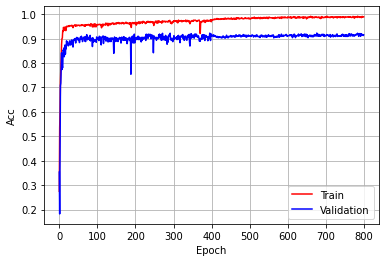

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

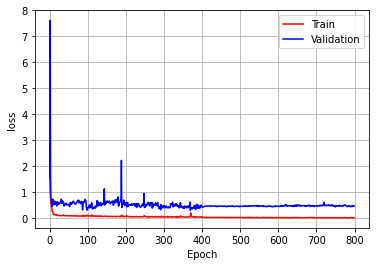

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()